# DELPHI SEIR+ Model

Based on DELPHI V2.0: https://www.covidanalytics.io/DELPHI_documentation_pdf

In [492]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp
import math, datetime

In [505]:
data = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
population = pd.read_csv("../data/us/demographics/county_populations.csv")

In [494]:
def get_derivatives(y, t, N, gamma, alpha, r_d, r_i, r_ri, r_rh, r_dth, p_dth, p_d, p_h):
    S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D = y
    
    dSdt = -alpha * gamma * S * I / N
    dEdt = alpha * gamma * S * I / N - r_i * E
    dIdt = r_i * E - r_d * I
    dARdt = r_d * (1 - p_dth) * (1 - p_d) * I - r_ri * AR
    dDHRdt = r_d * (1 - p_dth) * p_d * p_h * I - r_rh * DHR
    dDQRdt = r_d * (1 - p_dth) * p_d * (1 - p_h) * I - r_ri * DQR
    dADdt = r_d * p_dth * (1 - p_d) * I - r_dth * AD
    dDHDdt = r_d * p_dth * p_d * p_h * I - r_dth * DHD
    dDQDdt = r_d * p_dth * p_d * (1 - p_h) * I - r_dth * DQD
    #dTHdt = r_d * p_d * p_h * I
    #dDDdt = r_dth * (DHD + DQD)
    #dDTdt = r_d * p_d * I
    dRdt = r_ri * (AR + DQR) + r_rh * DHR
    dDdt = r_dth * (AD + DQD + DHD)
    #print(AD, DQD, DHD, dDdt)
    
    return dSdt, dEdt, dIdt, dARdt, dDHRdt, dDQRdt, dADdt, dDHDdt, dDQDdt, dRdt, dDdt

In [495]:
def test_fit(S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D, df, 
    case_wt=0, death_wt=2, c_case_wt=0, c_death_wt=0.05):
    case_err, death_err, c_case_err, c_death_err = 0, 0, 0, 0
    
    for i, row in df.iterrows():
        if i == 0:
            this_cases = DHR[i] + DHD[i] + DQR[i] + DQD[i]
            this_deaths = D[i]
        else:
            this_cases = DHR[i] + DHD[i] + DQR[i] + DQD[i] - (DHR[i-1] + DHD[i-1] + DQR[i-1] + DQD[i-1])
            this_deaths = D[i] - D[i-1]
    
        case_err += (row["cases"] - this_cases) ** 2
        death_err += (row["deaths"] - this_deaths) ** 2
        c_case_err += (row["c_cases"] - (DHR[i] + DHD[i] + DQR[i] + DQD[i])) ** 2
        c_death_err += (row["c_deaths"] - D[i]) ** 2
    
    case_err /= len(S)
    death_err /= len(S)
    c_case_err /= len(S)
    c_death_err /= len(S)
    
    return (case_wt * math.sqrt(case_err) + death_wt * math.sqrt(death_err) + 
            c_case_wt * math.sqrt(c_case_err) + c_death_wt * math.sqrt(c_death_err))



In [496]:
class HyperOpt(object):
    def __init__(self, population, data, y_init, timespace):
        self.data = data.copy()
        self.data.reset_index(inplace=True)
        self.y_init = y_init
        self.pop = population
        self.t = timespace
    
    def eval_model(self, params):
        result = odeint(get_derivatives, self.y_init, self.t, args=(self.pop, 
                                                                    params["gamma"],
                                                                    params["alpha"], 
                                                                    math.log(2) / params["T_d"], 
                                                                    math.log(2) / params["T_i"], 
                                                                    math.log(2) / params["T_ri"], 
                                                                    math.log(2) / params["T_rh"],
                                                                    math.log(2) / params["T_dth"],
                                                                    params["p_dth"], params["p_d"], params["p_h"]))
        
        S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D = result.T
        rmse = test_fit(S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D, self.data)
        return rmse
    
    def optimize_params(self, space, trials, algo, max_evals):
        result = fmin(fn=self.eval_model, space=space, algo=algo, max_evals=max_evals, trials=trials, verbose=False)
        return result, trials

Model Parameters

In [506]:
# If we use government response
def gamma(a, b, t):
    return 2 / math.pi * math.arctan(-(t - a) / b)

In [507]:
# Manually choose these parameters
T_d = 2                                 # Days to detection
T_i = 5                                 # Days to leave incubation
T_ri = 10                               # Days to recovery not in hospital
T_rh = 15                               # Days to recovery in hospital
gamma = 1                               # Don't model government response yet
p_d = 0.2                               # Percentage of cases detected
p_h = 0.15                              # Percentage of detected cases hospitalized

# Fit alpha, T_dth, p_dth to historical data

## Fitting One County

In [467]:
fips = 1001

In [468]:
pop = int(population.loc[population["FIPS"] == fips]["total_pop"])
df = data.loc[data["fips"] == fips]
df.reset_index(inplace=True)

df["c_deaths"], df["c_cases"] = 0, 0
for i, row in df.iterrows():   
    try:
        df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
    except Exception as e:
        df.at[i, "c_deaths"] = df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i, "cases"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [454]:
# Find first cases
infection_start = df.loc[df["cases"] > 0].first_valid_index()
#infection_start = 10
start_date = df.iloc[infection_start]["date"]

In [455]:
# Initial number of each category
E_init = 0
I_init = df.iloc[infection_start]["cases"]
AR_init = 0
AD_init = 0
DHR_init = I_init / 4
DHD_init = I_init / 4
DQR_init = I_init / 4
DQD_init = I_init / 4
R_init = 0
D_init = df.iloc[infection_start]["deaths"]
S_init = pop - I_init - D_init

y_init = S_init, E_init, I_init, AR_init, AD_init, DHR_init, DHD_init, DQR_init, DQD_init, R_init, D_init

In [456]:
t = np.linspace(0, len(df)-14-infection_start, len(df)-14-infection_start)

In [457]:
param_space = {
    "gamma": gamma,
    "alpha": hp.uniform("alpha", 0.2, 0.4),
    "T_d": T_d, "T_i": T_i, "T_ri": T_ri, "T_rh": T_rh,
    "T_dth": hp.uniform("T_dth", 5, 20),
    "p_dth": hp.uniform("p_dth", 0.01, 0.06),
    "p_d": p_d, "p_h": p_h
}

In [458]:
hopt = HyperOpt(pop, df[infection_start:-14], y_init, t)

In [459]:
optimized, trials = hopt.optimize_params(space=param_space, trials=Trials(), algo=tpe.suggest, max_evals=50)
print("Best parameters:\n", optimized)

Best parameters:
 {'T_dth': 5.173697410424606, 'alpha': 0.33503342036406136, 'p_dth': 0.026942273666178948}


In [460]:
t = np.linspace(0, len(df), len(df))

res = odeint(get_derivatives, y_init, t, args=(pop, gamma,
                                            optimized["alpha"], 
                                            math.log(2) / T_d, 
                                            math.log(2) / T_i, 
                                            math.log(2) / T_ri, 
                                            math.log(2) / T_rh,
                                            math.log(2) / optimized["T_dth"],
                                            optimized["p_dth"], p_d, p_h))

S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D = res.T

In [461]:
df["S"], df["I"], df["R"], df["D"], df["D_diff"], df["c_deaths"], df["c_cases"], df["C"] = 0, 0, 0, 0, 0, 0, 0, 0
for i, row in df.iterrows():
    if i < infection_start:
        df.loc[i, "S"] = 0
        df.loc[i, "I"] = 0
        df.loc[i, "R"] = 0
        df.loc[i, "D"] = 0
        df.loc[i, "D_diff"] = 0
    else:
        df.loc[i, "S"] = S[i-infection_start]
        df.loc[i, "I"] = I[i-infection_start]
        df.loc[i, "R"] = R[i-infection_start]
        df.loc[i, "D"] = D[i-infection_start]
        if i == infection_start:
            df.loc[i, "D_diff"] = D[i-infection_start]
        else:
            df.loc[i, "D_diff"] = D[i-infection_start] - D[i-1-infection_start]
    
    try:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
    except Exception as e:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i, "cases"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [462]:
#max_deaths = data["deaths"].max()
max_deaths = 0.00001 * pop
print(max_deaths)
df["D_diff"].clip(lower=0, upper=max_deaths, inplace=True)

0.5503600000000001


/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:7363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


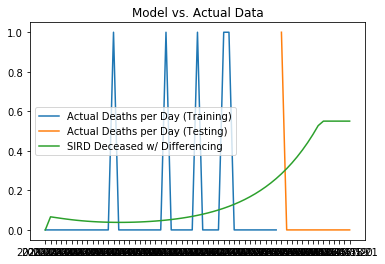

In [463]:
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=df[:-14], label='Actual Deaths per Day (Training)')
ax.plot('date', 'deaths', data=df[-14:], label='Actual Deaths per Day (Testing)')
ax.plot('date', 'D_diff', data=df, label='SIRD Deceased w/ Differencing')
#ax.plot('date', 'c_deaths', data=df, label="Actual Cumulative Deaths")
#ax.plot('date', 'c_cases', data=df, label="Actual Cumulative Cases")
#ax.plot('date', 'S', data=df, label="SIRD Susceptible")
#ax.plot('date', 'C', data=df, label="SIRD Infected + Recovered")
#ax.plot('date', 'D', data=df, label="SIRD Deceased")
plt.title("Model vs. Actual Data")
plt.legend()
plt.show()

# Generating a Submission

In [508]:
fips_list = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding="cp1252")

In [509]:
test_per = 0
pred_per = 21

In [510]:
ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = [], [], [], [], [], [], [], [], [], []
z_80 = 1.28
z_60 = 0.84
z_40 = 0.525
z_20 = 0.25

In [511]:
sample = pd.read_csv("../sample_submission.csv")
submission = sample.copy()

In [512]:
print(str(datetime.datetime.now())+"\n")

for idx, row in fips_list.iterrows():
    county = int(row["FIPS"])
    print("County " + str(county) + "...", end='\r', flush=True)
        
    if test_per > 0: df = data.loc[data["fips"] == county][:-test_per]
    else: df = data.loc[data["fips"] == county]
    df.reset_index(inplace=True)
    df["c_deaths"], df["c_cases"] = 0, 0
    for i, row in df.iterrows():   
        try:
            df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
        except Exception as e:
            df.at[i, "c_deaths"] = df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i, "cases"]
    
    try: 
        cum_deaths = df.iloc[-1]["c_deaths"]
    except IndexError as e:
        if len(df) == 0:
            print("No data found for county", str(county), ":", row["COUNTY"])
            continue
        else:
            cum_deaths = 0
        
    if cum_deaths >= 15:
        try:
            pop = int(population.loc[population["FIPS"] == county]["total_pop"])
        except TypeError as e:
            print("No population found for county", str(county), ":", row["COUNTY"])
            print("This county has at least 15 cumulative deaths!")
            raise e
            
        # Find first cases
        infection_start = df.loc[df["cases"] > 0].first_valid_index()
        start_date = df.iloc[infection_start]["date"]

        # Initial numbers
        E_init = 0
        I_init = df.iloc[infection_start]["cases"]
        AR_init = 0
        AD_init = 0
        DHR_init = I_init / 4
        DHD_init = I_init / 4
        DQR_init = I_init / 4
        DQD_init = I_init / 4
        R_init = 0
        D_init = df.iloc[infection_start]["deaths"]
        S_init = pop - I_init - D_init

        y_init = S_init, E_init, I_init, AR_init, AD_init, DHR_init, DHD_init, DQR_init, DQD_init, R_init, D_init

        t = np.linspace(0, len(df)-infection_start, len(df)-infection_start)

        param_space = {
            "gamma": gamma,
            "alpha": hp.uniform("alpha", 0.2, 0.4),
            "T_d": T_d, "T_i": T_i, "T_ri": T_ri, "T_rh": T_rh,
            "T_dth": hp.uniform("T_dth", 5, 20),
            "p_dth": hp.uniform("p_dth", 0.01, 0.06),
            "p_d": p_d, "p_h": p_h
        }

        hopt = HyperOpt(pop, df[infection_start:], y_init, t)
        optimized, trials = hopt.optimize_params(space=param_space, trials=Trials(), algo=tpe.suggest, max_evals=100)

        t = np.linspace(0, len(df) + test_per + pred_per, len(df) + test_per + pred_per)
        
        res = odeint(get_derivatives, y_init, t, args=(pop, gamma,
                                            optimized["alpha"], 
                                            math.log(2) / T_d, 
                                            math.log(2) / T_i, 
                                            math.log(2) / T_ri, 
                                            math.log(2) / T_rh,
                                            math.log(2) / optimized["T_dth"],
                                            optimized["p_dth"], p_d, p_h))

        S, E, I, AR, AD, DHR, DHD, DQR, DQD, R, D = res.T
        
        max_deaths = 0.000005 * pop

        date = datetime.date.fromisoformat(df.iloc[0]["date"]) + datetime.timedelta(days=int(infection_start))
        for i, ddata in enumerate(D):
            this_id = date.isoformat() + "-" + str(county)
            date += datetime.timedelta(days=1)

            if i == 0:
                mid = ddata
            else:
                mid = ddata - D[i - 1]
                
            if mid > max_deaths: mid = max_deaths
            
            sd = 3 * math.sqrt(mid)

            ids.append(this_id)
            i10.append(mid - sd * z_80)
            i20.append(mid - sd * z_60)
            i30.append(mid - sd * z_40)
            i40.append(mid - sd * z_20)
            i50.append(mid)
            i60.append(mid + sd * z_20)
            i70.append(mid + sd * z_40)
            i80.append(mid + sd * z_60)
            i90.append(mid + sd * z_80)
            
            try:
                ss_location = submission.index[submission["id"] == str(this_id)][0]
                submission.at[ss_location,"10"] = mid - sd * z_80
                submission.at[ss_location,"20"] = mid - sd * z_60
                submission.at[ss_location,"30"] = mid - sd * z_40
                submission.at[ss_location,"40"] = mid - sd * z_20
                submission.at[ss_location,"50"] = mid
                submission.at[ss_location,"60"] = mid + sd * z_20
                submission.at[ss_location,"70"] = mid + sd * z_40
                submission.at[ss_location,"80"] = mid + sd * z_60
                submission.at[ss_location,"90"] = mid + sd * z_80
            except IndexError as e:
                #print(date)
                continue
    
    else:
        date = datetime.date.fromisoformat(df.iloc[0]["date"])
        for i in range(len(df) + test_per + pred_per):
            this_id = date.isoformat() + "-" + str(county)
            date += datetime.timedelta(days=1)
            
            ids.append(this_id)
            i10.append(0)
            i20.append(0)
            i30.append(0)
            i40.append(0)
            i50.append(0)
            i60.append(0)
            i70.append(0)
            i80.append(0)
            i90.append(0)

print("\n" + str(datetime.datetime.now()))


2020-05-25 21:55:05.367415



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No data found for county 2013 : Aleutians East Borough
No data found for county 2016 : Aleutians West Census Area
No data found for county 2060 : Bristol Bay Borough
No data found for county 2068 : Denali Borough
No data found for county 2068 : Denali Census Area
No data found for county 2070 : Dillingham Census Area
No data found for county 2100 : Haines Borough
No data found for county 2164 : Lake and Peninsula Borough
No data found for county 2068 : Denali Census Area
No data found for county 2185 : North Slope Borough
No data found for county 2201 : Prince of Wales-Hyder Census Area
No data found for county 2201 : Prince of Wales-Outer Ketchikan Census Area
No data found for county 2232 : Hoonah-Angoon Census Area
No data found for county 2232 : Skagway Municipality
No data found for county 2232 : Skagway/Hoonah/Angoon Census Area
No data found for county 2270 : Wade Hampton Census Area
No data found for county 2280 : Petersburg Borough
No data found for county 2280 : Wrangell City

No data found for county 46077 : Kingsbury County
No data found for county 46095 : Mellette County
No data found for county 46105 : Perkins County
No data found for county 46107 : Potter County
No data found for county 46113 : Shannon County
No data found for county 48023 : Baylor County
No data found for county 48033 : Borden County
No data found for county 48105 : Crockett County
No data found for county 48109 : Culberson County
No data found for county 48137 : Edwards County
No data found for county 48155 : Foard County
No data found for county 48229 : Hudspeth County
No data found for county 48235 : Irion County
No data found for county 48243 : Jeff Davis County
No data found for county 48261 : Kenedy County
No data found for county 48263 : Kent County
No data found for county 48269 : King County
No data found for county 48271 : Kinney County
No data found for county 48301 : Loving County
No data found for county 48311 : McMullen County
No data found for county 48327 : Menard Count

In [513]:
submission["10"] = submission["10"].apply(lambda x: x if x >= 1 else 0)
submission["20"] = submission["20"].apply(lambda x: x if x >= 1 else 0)
submission["30"] = submission["30"].apply(lambda x: x if x >= 1 else 0)
submission["40"] = submission["40"].apply(lambda x: x if x >= 1 else 0)
submission["50"] = submission["50"].apply(lambda x: x if x >= 1 else 0)
submission["60"] = submission["60"].apply(lambda x: x if x >= 1 else 0)
submission["70"] = submission["70"].apply(lambda x: x if x >= 1 else 0)
submission["80"] = submission["80"].apply(lambda x: x if x >= 1 else 0)
submission["90"] = submission["90"].apply(lambda x: x if x >= 1 else 0)

In [514]:
submission.to_csv("delphi_checkpoint3.csv", index=False)

In [436]:
predictions = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})

In [437]:
predictions["10"] = predictions["10"].apply(lambda x: x if x >= 1 else 0)
predictions["20"] = predictions["20"].apply(lambda x: x if x >= 1 else 0)
predictions["30"] = predictions["30"].apply(lambda x: x if x >= 1 else 0)
predictions["40"] = predictions["40"].apply(lambda x: x if x >= 1 else 0)
predictions["50"] = predictions["50"].apply(lambda x: x if x >= 1 else 0)
predictions["60"] = predictions["60"].apply(lambda x: x if x >= 1 else 0)
predictions["70"] = predictions["70"].apply(lambda x: x if x >= 1 else 0)
predictions["80"] = predictions["80"].apply(lambda x: x if x >= 1 else 0)
predictions["90"] = predictions["90"].apply(lambda x: x if x >= 1 else 0)

In [438]:
predictions.to_csv("delphi_test.csv", index=False)

### Results

DD max 0.00001 * population: 0.1941738966079089 \
DD max = 750: 0.22831699694581553 \
DD max 0.0000075 * population: 0.19000998642972566 \
DD max 0.000005 * population: 0.18740148604657209


In [484]:
submission.loc[submission["id"] == "2020-05-23-1017"]

,id,10,20,30,40,50,60,70,80,90
167607,2020-05-23-1017,-1.411351,-0.867942,-0.478911,-0.13928,0.169475,0.47823,0.817861,1.206892,1.750301
